Kaggle competition: https://www.kaggle.com/c/digit-recognizer/

https://wandb.ai/mlteamaau/MNIST_MLP/runs/x6nei9r3?workspace=user-qfaithencz
https://www.kaggle.com/code/eisbarinkaltenpolar/homework-3

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


We need to import Torch's libraries

In [2]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import wandb
#wandb.init(project='MNIST_MLP', save_code=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Data preparation

A custom dataset which uses the CSV from Kaggle, avoid downloading the dataset from internet

In [4]:
class MyMNISTDataset(Dataset):
    
    def __init__(self, file_path, transform = transforms.Compose([transforms.ToPILImage()]), test_data=False, use_gpu=torch.cuda.is_available()):
        # read the data
        df = pd.read_csv(file_path)
        # for test data we don't have any target
        # MNIST images are 28 by 28, grey colors
        if test_data:
            self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
        self.transform = transform
        self.use_gpu = use_gpu
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        data = self.transform(self.X[idx])
        if self.y is not None:
            target = self.y[idx]
            if self.use_gpu:
                data = data.cuda()
                target = target.cuda()
            return data, target
        else:
            if self.use_gpu:
                data = data.cuda()
            return data

In [5]:
transformations=transforms.Compose([transforms.ToPILImage(), 
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = MyMNISTDataset('/kaggle/input/digit-recognizer/train.csv', transform=transformations, test_data=False)
test_dataset = MyMNISTDataset('/kaggle/input/digit-recognizer/test.csv', transform=transformations, test_data=True)

batch_size = 16


training_size = int(0.6 * len(train_dataset))
validation_size = int(0.4 * len(train_dataset))


train, val = torch.utils.data.random_split(train_dataset,
                                           [training_size, validation_size],
                                           generator=torch.Generator().manual_seed(0))

trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(val, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)



# TODO split train between validation and training set
# create data loader for train and test set

## MLP

### Define model architecture
You need to reach at least 70% accuracy on the test set

In [6]:
# TODO define a multilayer perceptron for image recognition
def weight_init(m):
    if isinstance(m,nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)
        return m

class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
        self.ln1 = weight_init(nn.Linear(28*28,14*14))
        self.ln2 = weight_init(nn.Linear(14*14,10))
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.sigmoid(self.ln1(x))
        x = self.tanh(self.ln2(x))
        return x

### Init the model and put it on GPU/TPU

### Training loop
Log the accuracy and the loss to wandb

In [8]:
num_epochs = 50 # should be more than enought, but can be changed
lr = 0.1 # e.q to 0.003, you can change it if needed

net = Net()
if torch.cuda.is_available():
    net = net.to('cuda')
    
criterion = nn.CrossEntropyLoss()
criterion.to('cuda')
optimizer = torch.optim.SGD(net.parameters(), lr=lr)


for epoch in range(num_epochs):
    
    training_loss = 0
    acctrain = 0
    acc = []
    net.train()
    
    for images,target in trainloader:
        optimizer.zero_grad()
        predictions = net.forward(images)
        loss = criterion(predictions,target)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        acc.append((torch.argmax(predictions, dim = 1) == target).float().mean().item())
        
    training_loss /= len(trainloader)
    acctrain = sum(acc)/len(acc)
    
    validation_loss = 0
    accvalid = 0
    acc = []
    net.eval()
    
    for images,target in valloader:
        with torch.no_grad():
            predictions = net.forward(images)
            loss = criterion(predictions,target)
            validation_loss += loss.item()
            acc.append((torch.argmax(predictions, dim = 1) == target).float().mean().item())
            
    validation_loss /= len(valloader)
    accvalid = sum(acc)/len(acc)


    print(f"epoch {epoch+1} is finished")
    torch.save(net.state_dict(), 'saved_model.pth')
        
    #wandb.log({'training_loss': training_loss, 'validation_loss': validation_loss, "acc train": acctrain, "acc valid": accvalid})

print("Done")

epoch 1 is finished
epoch 2 is finished
epoch 3 is finished
epoch 4 is finished
epoch 5 is finished
epoch 6 is finished
epoch 7 is finished
epoch 8 is finished
epoch 9 is finished
epoch 10 is finished
epoch 11 is finished
epoch 12 is finished
epoch 13 is finished
epoch 14 is finished
epoch 15 is finished
epoch 16 is finished
epoch 17 is finished
epoch 18 is finished
epoch 19 is finished
epoch 20 is finished
epoch 21 is finished
epoch 22 is finished
epoch 23 is finished
epoch 24 is finished
epoch 25 is finished
epoch 26 is finished
epoch 27 is finished
epoch 28 is finished
epoch 29 is finished
epoch 30 is finished
epoch 31 is finished
epoch 32 is finished
epoch 33 is finished
epoch 34 is finished
epoch 35 is finished
epoch 36 is finished
epoch 37 is finished
epoch 38 is finished
epoch 39 is finished
epoch 40 is finished
epoch 41 is finished
epoch 42 is finished
epoch 43 is finished
epoch 44 is finished
epoch 45 is finished
epoch 46 is finished
epoch 47 is finished
epoch 48 is finished
e

### Make prediction
And submit to Kaggle for grading

In [11]:
with torch.no_grad():
    net.eval()
    test_pred = torch.LongTensor()
    for i, data in enumerate(testloader):
        output = net(data)
        _, predicted = torch.max(output.data, 1)
        predicted = predicted.cpu()
        test_pred = torch.cat((test_pred, predicted), dim=0)

    out_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], test_pred.numpy()], columns=['ImageId', 'Label'])
    out_df.to_csv('submission.csv', index=False)

### Top 10 misclassified images by class probability

In [9]:
import matplotlib.pyplot as plt


unshuffle_train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=False)
with torch.no_grad():
    net.eval()
    missclasified = torch.DoubleTensor()
    for batch_idx, (data, target) in enumerate(unshuffle_train_loader):
        output = net(data)
        prob, predicted = torch.max(output.data, 1)
        predicted = predicted.cpu()
        target = target.cpu()
        prob = prob.cpu().double()
        missclassified_prob = torch.where(predicted == target, 0., prob)
        missclasified = torch.cat((missclasified, missclassified_prob), dim=0)
    most_misclassified = torch.argsort(missclasified, descending=True)
    top_ten_misclassified = most_misclassified[:10]

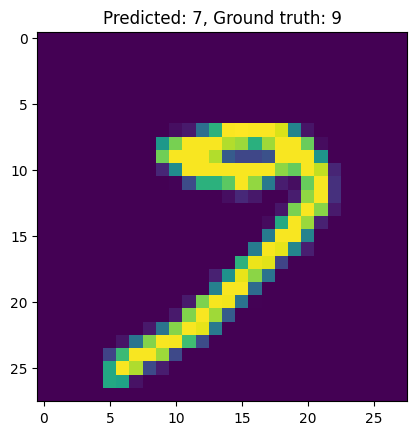

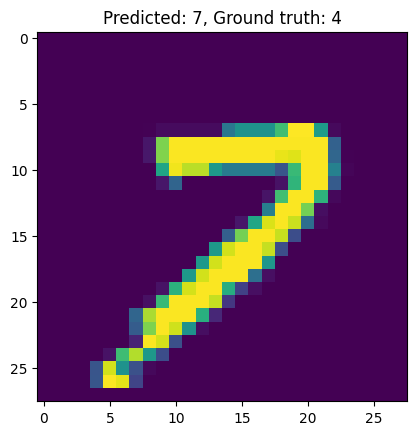

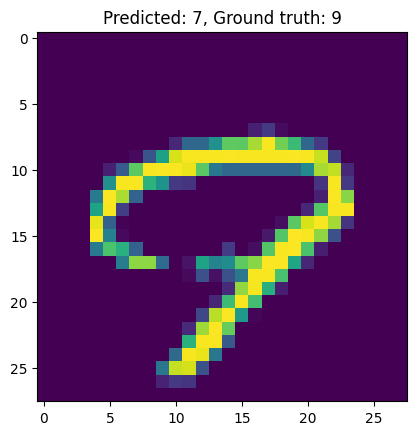

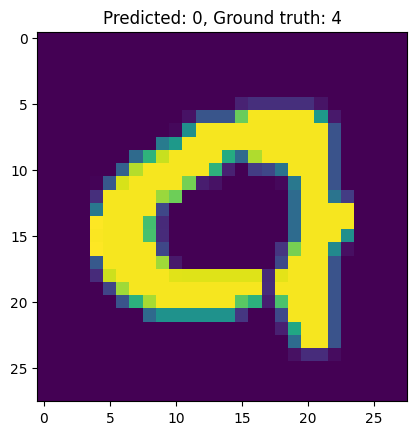

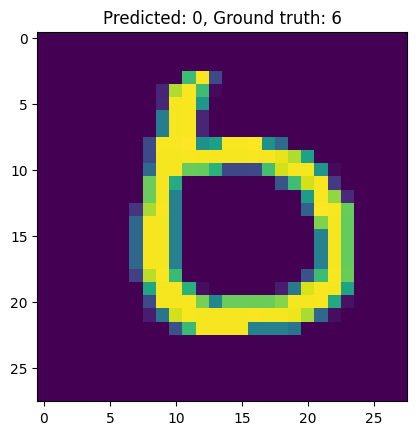

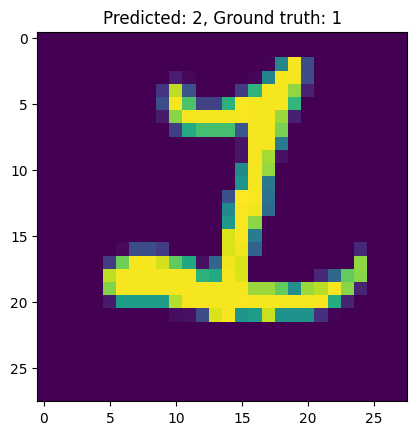

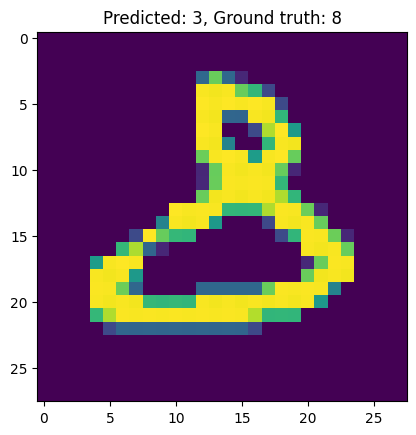

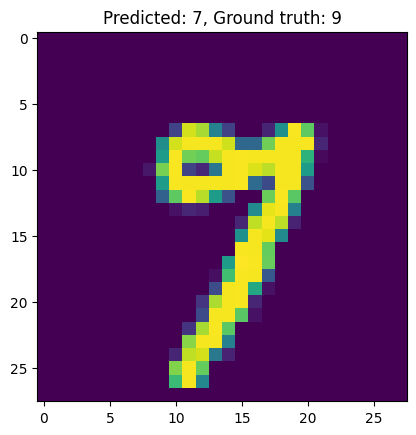

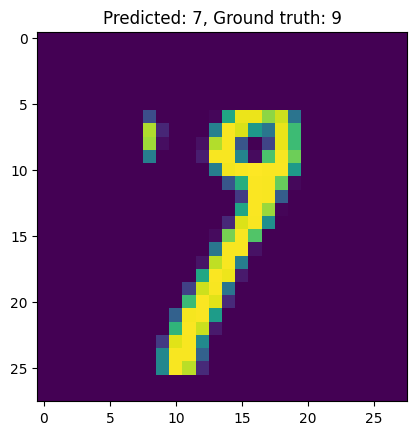

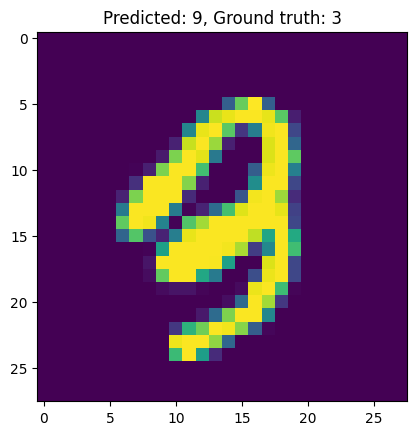

In [11]:
for misclassified in top_ten_misclassified:
    plt.imshow(train_dataset[misclassified][0].cpu().reshape(28,28))
    with torch.no_grad():
        data, target = train_dataset[misclassified]
        data = data.reshape(1, 1, 28,28)
        output = net(data)
        _, predicted = torch.max(output.data, 1)
        plt.title(f'Predicted: {predicted.item()}, Ground truth: {target}')
    plt.show()